# Blackjack Monte Carlo

This notebook works thru the problem of first visit MC prediction for estimating V ≈ v<sub>π.
    
We apply MC control to create an optimal policy given the environment we previously created.
    
Rewards of +1, -1, and 0 are given for winning, losing, and drawing, respectively. 


    
Objects to create:
- environment to simulate the blackjack game rules
- entity objects to sumulate players and the dealer
- value estimation function
- policy improvement function

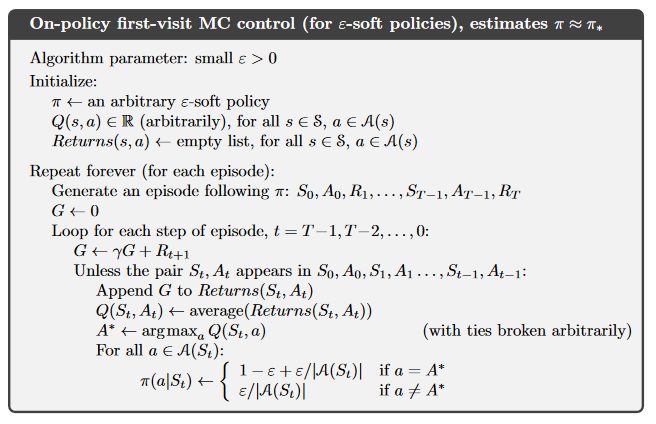

In [1]:
import itertools
import numpy as np
import seaborn as sns
import pandas as pd


In [2]:
#build environment
class blackjack_class():
    def __init__(self):
        self.cards_in_play = {"player":[],"dealer":[]}
                
        self.suits = ['h','d','s','c']
        self.values = [['a', 11]] + [[str(i), i] for i in range(2,11)] + [['j', 10],['q', 10],['k', 10]]
        
        self.deck = []
        for i in self.suits:
            for j in self.values:
                self.deck.append([i, j[0], j[1]])
                
        #print(self.deck)

    def check_hand(self, entity, flag = None):
        """
        checks if hand is bust or open
        """
        #print(entity, self.cards_in_play[entity])
        total = sum([i[2] for i in self.cards_in_play[entity]])
       
        if total > 21:

            if flag != "post":
                if self.flip_ace(entity):
                    bust, total, usable_ace, dealer_show = self.check_hand(entity)
                else:
                    bust = True
            else:
                bust = True
        else:
            bust = False
            
        usable_ace = 0
        for i in range(len(self.cards_in_play[entity])):
            if self.cards_in_play[entity][i][1] == 'a':
                usable_ace = 1

        return bust, total, usable_ace, self.dealer_show

    def deal_hand(self, player, dealer):
        
        self.cards_in_play = {"player":[],"dealer":[]}
        #align the cards for the deal
        player.new_hand()
        dealer.new_hand()
        
        self.deal = np.random.choice([i for i in range(52)], size=52, replace=False)
        
        self.cards_in_play["player"].append(self.deck[self.deal[0]].copy())
        self.cards_in_play["player"].append(self.deck[self.deal[2]].copy())
        self.cards_in_play["dealer"].append(self.deck[self.deal[1]].copy())
        self.cards_in_play["dealer"].append(self.deck[self.deal[3]].copy())
        
        self.card_count = 4
        
        #check, total, usable_ace = self.check_hand("player")
        
        self.dealer_show = self.deck[self.deal[3]][1]
        if self.dealer_show in ['j','q','k']:
            self.dealer_show = '10'
        #print(self.dealer_show)
        
    def deal_hit(self, entity):
        self.cards_in_play[entity].append(self.deck[self.deal[self.card_count]].copy())
        self.card_count = self.card_count + 1
        check, total, usable_ace, dealer_show = self.check_hand(entity)
        
        return self.cards_in_play["player"], total, self.dealer_show, check
    
    def flip_ace(self, entity):
        cards = self.cards_in_play[entity]
        #need logic to detect ace and check if it is already 1 to exit or you end up with infinite loop
        #return ace_check flag

        for i in range(len(cards)):
            ace_flip = False
            cards[i]
            if cards[i][1] == 'a':
                if cards[i][2] == 11:
                    cards[i][2] = 1
                    ace_flip = True
                    
        
        self.cards_in_play[entity] = cards
        
        return ace_flip

    def give_data(self):
        
        dealer_bust, dealer_total, usable_ace, dealer_show = self.check_hand("dealer", "post")
        player_bust, player_total, usable_ace, dealer_show = self.check_hand("player", "post")
        
        return [self.cards_in_play["player"], self.dealer_show, dealer_bust, dealer_total, player_bust, player_total]
    

In [3]:
#entity object
class entity_class():
    #modify to intake policies if player is the entity type
    """
    simple object to follow typical house rules, hit on 16 stay on 17
    """
    def __init__(self, entity = None, stick = None, policy = None):
        self.entity = entity
        self.stick = stick
        self.policy = policy
        self.tracking = []
        self.dealer_show = ""
        self.usable_ace = 0
        
        self.total = 0        

        
    def new_hand(self):
        self.total = 0
        self.usable_ace = 0
        self.tracking = []
        self.dealer_show = ""
        
    def check_total(self, environment):
        """
        checks dealers total
        """
        bust, self.total, self.usable_ace, self.dealer_show = environment.check_hand(self.entity)
        
        if not bust:
        
            if self.entity == "dealer":
                if self.total < self.stick:
                    self.take_hit(environment)
            else:
                #check if state exists in policy
                #policy is dict object using (self.usable_ace, self.dealer_show, self.player_total):[p_0,p_1]
                #where p_0 + p_1 = 1
                #print(self.total)
                if self.total < 12:
                    self.take_hit(environment)
                    
                else:

                    if self.total == 21:
                        action = 0
                    
                    elif (self.usable_ace, self.dealer_show, self.total) in self.policy.keys():
                        policy_values = self.policy[(self.usable_ace, self.dealer_show, self.total)]

                        #if yes pick action based on probability 1
                        action =  np.random.binomial(1, policy_values[1], None)

                    else:
                        #else random action (1 = hit, 0 = stick)
                        action =  np.random.binomial(1, .5, None)

                    #clock state and action
                    self.tracking.append([self.usable_ace, self.dealer_show, self.total, action])

                    #take action
                    if action:
                        self.take_hit(environment)       
            
        
    def take_hit(self, environment):
        bust, self.total, self.dealer_show, check = environment.deal_hit(self.entity)
        self.check_total(environment)
            
    def give_tracking(self):
        return self.tracking
    
    def update_policy(self, policy):
        self.policy = policy
            

In [4]:
house= blackjack_class()
player = entity_class("player", policy = {"none":0})
dealer = entity_class("dealer", 17)


In [5]:
n = 500000
epsilon = 0.10
state_values = []
states = []
returns = []
gamma = .90

policy = {(None, None, None):[0,0]}

for i in range(n):
    player.update_policy(policy)
    
    house.deal_hand(player, dealer)

    player.check_total(house)

    dealer.check_total(house)

    response_list = house.give_data()

    #print(response_list)

    #player wins
    if (response_list[4] == False and response_list[5] > response_list[3]) or (response_list[4] == False and response_list[2] == True):
        value = 1
    #tie
    elif response_list[4] == False and response_list[3] == response_list[5]:
        value = 0
    #house wins (always)
    elif response_list[4] == True or (response_list[2] == False and response_list[5] < response_list[3] and response_list[4] == False):
        value = -1
    else:
        continue
        print("print value error check")
        #print(response_list)

    state_actions = player.give_tracking()

    #reverse states (last to first)    
    state_actions = state_actions[::-1]
    
    #print(state_actions)
    
    prior_visited_states = []

    # set starting g
    G = 0

    #loop thru states
    for i in range(len(state_actions)):

        #extract state and state value (G)
        state = state_actions[i]
        #print(state)

        #should be if reqards occurred at every state
        if i == 0:

            G = (G * gamma) + value

        #since rewards is at the end it becomes
        else:

            G = (G * gamma)

        # if previosuly visited state during current episode 
        # this is for first visit
        if state not in prior_visited_states:

            prior_visited_states.append(state)

            #update state values
            #print(states)
            #print(state)
            
            #get index
            try:
                #print(1)
                index = states.index(state)
                #print(2)
                returns[index].append(G)
                #print(3)
                temp = np.mean(returns[index])
                #print(returns[index], np.mean(returns[index]))
                state_values[index] = temp
                #print("try success")
            except:
                #print("try fail")
                states.append(state)
                temp = G
                returns.append([G])
                state_values.append(G)

            #policy improvement
            action = state[3]
            if action:
                action_conv = 0             
                
            else: 
                action_conv = 1
                
            state_conv = [state[0],state[1],state[2], action_conv]
                
            index = states.index(state)
            return_actual = temp
            
            try:
                index_conv = states.index(state_conv)
                return_conv = np.mean(returns[index_conv])
            except:
                return_conv = -np.inf
             
            #greedy action
            max_val = max(return_actual, return_conv)
            
            #set dummy values for policy probs
            policy_actions = [0,0]
            
            #assign probs with epsilon soft method
            if max_val == return_actual:
                policy_actions[action] = round(1 - epsilon + (epsilon / 2),2)
                policy_actions[action_conv] = round(epsilon / 2 ,2)                

            else:
                policy_actions[action_conv] = round(1 - epsilon + (epsilon / 2),2)
                policy_actions[action] = round(epsilon / 2 ,2)  
                
            
            policy[(state[0],state[1],state[2])] = policy_actions
                
            
            
            

 

In [6]:
policy

{(None, None, None): [0, 0],
 (0, '8', 16): [0.05, 0.95],
 (0, '6', 15): [0.95, 0.05],
 (1, '9', 20): [0.95, 0.05],
 (0, '9', 15): [0.05, 0.95],
 (0, '2', 20): [0.95, 0.05],
 (0, '10', 18): [0.95, 0.05],
 (0, '8', 15): [0.05, 0.95],
 (0, '8', 21): [0.95, 0.05],
 (0, '8', 18): [0.95, 0.05],
 (0, '6', 13): [0.05, 0.95],
 (0, '10', 14): [0.05, 0.95],
 (0, '10', 17): [0.95, 0.05],
 (0, '10', 12): [0.05, 0.95],
 (0, '6', 19): [0.95, 0.05],
 (0, '4', 19): [0.95, 0.05],
 (0, '4', 13): [0.95, 0.05],
 (0, '5', 12): [0.95, 0.05],
 (0, '3', 20): [0.95, 0.05],
 (1, '7', 21): [0.95, 0.05],
 (0, '9', 18): [0.95, 0.05],
 (0, '9', 14): [0.05, 0.95],
 (0, '6', 21): [0.95, 0.05],
 (0, '6', 17): [0.95, 0.05],
 (0, '6', 16): [0.95, 0.05],
 (0, '5', 19): [0.95, 0.05],
 (0, '5', 21): [0.95, 0.05],
 (0, '7', 21): [0.95, 0.05],
 (0, '9', 12): [0.05, 0.95],
 (0, '10', 21): [0.95, 0.05],
 (0, '10', 19): [0.95, 0.05],
 (0, '10', 13): [0.05, 0.95],
 (0, '8', 14): [0.05, 0.95],
 (0, 'a', 18): [0.95, 0.05],
 (1, '5

In [7]:
#check as expectation is that at 18 w/o a usable ace you should most def stick as the odds of getting a bust are high
policy[(0, 'a', 18)]

[0.95, 0.05]

In [8]:
states

[[0, '8', 16, 1],
 [0, '6', 15, 0],
 [1, '9', 20, 0],
 [0, '9', 15, 0],
 [0, '2', 20, 1],
 [0, '10', 18, 1],
 [0, '8', 15, 0],
 [0, '8', 21, 0],
 [0, '8', 18, 1],
 [0, '6', 13, 0],
 [0, '10', 18, 0],
 [0, '10', 14, 0],
 [0, '10', 17, 1],
 [0, '10', 12, 1],
 [0, '6', 19, 0],
 [0, '4', 19, 0],
 [0, '4', 13, 1],
 [0, '5', 12, 0],
 [0, '3', 20, 0],
 [1, '7', 21, 0],
 [0, '9', 18, 0],
 [0, '9', 14, 1],
 [0, '6', 21, 0],
 [0, '6', 17, 1],
 [0, '6', 16, 0],
 [0, '5', 19, 1],
 [0, '5', 21, 0],
 [0, '7', 21, 0],
 [0, '9', 12, 0],
 [0, '10', 21, 0],
 [0, '10', 19, 1],
 [0, '10', 13, 0],
 [0, '8', 14, 1],
 [0, 'a', 18, 1],
 [1, '5', 16, 0],
 [0, '5', 15, 1],
 [0, '10', 20, 0],
 [1, '5', 21, 0],
 [0, '3', 15, 1],
 [0, '10', 15, 1],
 [0, '10', 16, 0],
 [0, '9', 16, 1],
 [0, 'a', 15, 1],
 [0, '8', 13, 1],
 [0, '7', 17, 1],
 [0, '7', 15, 1],
 [0, '5', 16, 1],
 [1, '2', 14, 0],
 [0, '8', 20, 0],
 [0, '2', 14, 1],
 [0, '5', 13, 1],
 [0, '3', 14, 0],
 [0, '9', 17, 0],
 [1, '7', 19, 0],
 [1, '7', 17, 1],

In [9]:
print(len(states))

380


In [10]:
print(len(state_values))

380


In [11]:
print(len(returns))

380


In [12]:
output = []

for p in policy.keys():
    if p == (None, None, None):
        continue
    action_probs = policy[p]
    choice = np.argmax(action_probs)
    output.append([p[0],p[1],p[2],choice])
    
pdf_policy_choices = pd.DataFrame(data = output, columns = ["usable_ace","dealer_show","player_total","action"])


# display policy actions


In [13]:
def plot_heat(df):
    
    df = df.pivot(index='player_total', columns='dealer_show', values='action')
    
    df = df[['2', '3', '4', '5', '6', '7', '8', '9', '10', 'a']]
    
    df = df.sort_index(ascending=False)

    sns.heatmap(df)

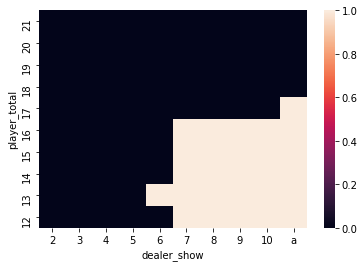

In [14]:
plot_heat(pdf_policy_choices[pdf_policy_choices["usable_ace"] == 0])

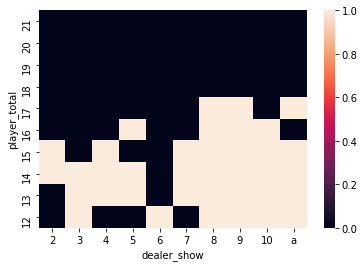

In [15]:
plot_heat(pdf_policy_choices[pdf_policy_choices["usable_ace"] == 1])